In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob, os
import numpy as np
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

(17931, 96, 96) (6000, 3)


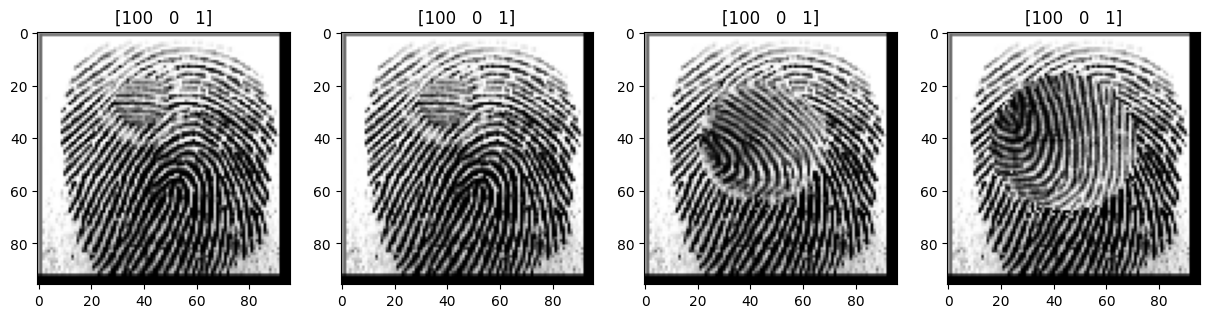

In [2]:
x_real = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_easy.npz')['data']
x_easy = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_easy.npz')['data']
x_medium = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_medium.npz')['data']
x_hard = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_hard.npz')['data']
y_real = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_real.npy')
y_easy = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_easy.npy')
y_medium = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_medium.npy')
y_hard = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)

plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)

plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)

plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)

plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')


C:\Users\h4uh4\AppData\Roaming\Python\Python310\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


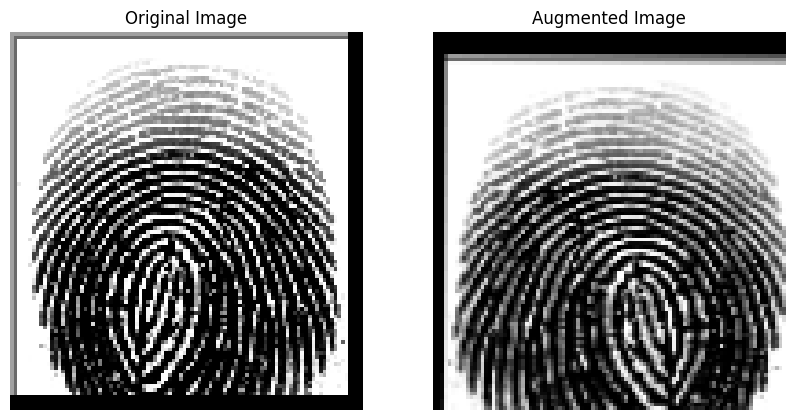

In [ ]:
import cv2
import matplotlib.pyplot as plt
import albumentations as A

image = cv2.imread('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/Real/1__M_Left_index_finger.BMP')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, rotate=(-5, 5), p=0.7),
])
augmented = augment(image=image)
augmented_image = augmented['image']


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')


plt.subplot(1, 2, 2)
plt.title("Augmented Image")
plt.imshow(augmented_image)
plt.axis('off')

plt.show()

In [ ]:
x_real = x_real[:len(y_real)]

x_data = np.concatenate([x_real, x_easy, x_medium, x_hard], axis=0)
y_data = np.concatenate([y_real, y_easy, y_medium, y_hard], axis=0)

print(f"x_data shape: {x_data.shape}")
print(f"y_data shape: {y_data.shape}")


half_size = len(x_data) // 2

x_data_half = x_data[:half_size] 
y_data_half = y_data[:half_size]  

print(f"x_data_half shape: {x_data_half.shape}")
print(f"y_data_half shape: {y_data_half.shape}")


assert x_data_half.shape[0] == y_data_half.shape[0], "Jumlah sample x_data dan y_data tidak sama!"

x_temp, x_test, y_temp, y_test = train_test_split(x_data_half, y_data_half, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)

print(f"Train set size: {x_train.shape[0]} samples")
print(f"Validation set size: {x_val.shape[0]} samples")
print(f"Test set size: {x_test.shape[0]} samples")

x_data shape: (55270, 96, 96)
y_data shape: (55270, 3)
x_data_half shape: (27635, 96, 96)
y_data_half shape: (27635, 3)
Train set size: 16581 samples
Validation set size: 5527 samples
Test set size: 5527 samples


In [ ]:
x_train = np.expand_dims(x_train, -1).astype('float32') / 255.
x_val = np.expand_dims(x_val, -1).astype('float32') / 255.
x_test = np.expand_dims(x_test, -1).astype('float32') / 255.

Memory usage: 82.6%


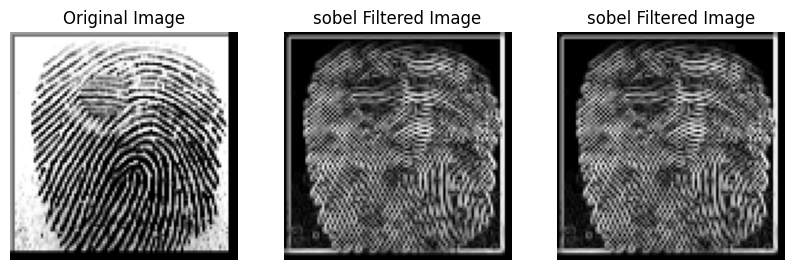

In [ ]:
import cv2
import numpy as np
import psutil
import matplotlib.pyplot as plt

def apply_sobel_filter(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  
    return cv2.magnitude(sobel_x, sobel_y)  


x_train_sobel = np.array([apply_sobel_filter(img.squeeze()) for img in x_train])
x_val_sobel = np.array([apply_sobel_filter(img.squeeze()) for img in x_val])
x_test_sobel = np.array([apply_sobel_filter(img.squeeze()) for img in x_test])


print(f"Memory usage: {psutil.virtual_memory().percent}%")


plt.figure(figsize=(10, 5))


plt.subplot(1, 3, 1)
plt.imshow(x_train[0], cmap='gray')  
plt.title("Original Image")
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(x_train_sobel[0], cmap='gray')  
plt.title("sobel Filtered Image")
plt.axis('off')


plt.subplot(1, 3, 3)
sobel_result = apply_sobel_filter(x_train[0])  
plt.imshow(sobel_result, cmap='gray')
plt.title("sobel Filtered Image")
plt.axis('off')

plt.show()


In [ ]:
import gc


gc.collect()


7326

In [ ]:

x_train_sobel = np.nan_to_num(x_train_sobel)
x_val_sobel = np.nan_to_num(x_val_sobel)
x_test_sobel = np.nan_to_num(x_test_sobel)


x_train_sobel = np.expand_dims(x_train_sobel, -1).astype('float32') / np.max(x_train_sobel)
x_val_sobel = np.expand_dims(x_val_sobel, -1).astype('float32') / np.max(x_val_sobel)
x_test_sobel = np.expand_dims(x_test_sobel, -1).astype('float32') / np.max(x_test_sobel)


In [ ]:
from tensorflow.keras.utils import Sequence


class PairGenerator(Sequence):
    def __init__(self, x, y, x_real, y_real, batch_size=32, augment_fn=None):
        self.x = x
        self.y = y
        self.x_real = x_real
        self.y_real = y_real
        self.batch_size = batch_size
        self.augment_fn = augment_fn

        
        self.label_real_dict = {}
        for idx, label in enumerate(self.y_real):
            key = ''.join(label.astype(str)).zfill(6)
            if key not in self.label_real_dict:
                self.label_real_dict[key] = []
            self.label_real_dict[key].append(idx)

        self.label_keys = list(self.label_real_dict.keys())

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.x))

        x1_batch = self.x[start:end]
        y_batch = self.y[start:end]
        batch_size = len(x1_batch)

        x2_batch = np.empty_like(x1_batch)
        labels = np.zeros((batch_size, 1), dtype=np.float32)

        for i, label in enumerate(y_batch):
            key = ''.join(label.astype(str)).zfill(6)

            if random.random() > 0.5 and key in self.label_real_dict:
                idx = random.choice(self.label_real_dict[key])
                x2 = self.x_real[idx]
                labels[i] = 1.
            else:
                while True:
                    unmatch_key = random.choice(self.label_keys)
                    if unmatch_key != key:
                        idx = random.choice(self.label_real_dict[unmatch_key])
                        x2 = self.x_real[idx]
                        break
                labels[i] = 0.

            x2_batch[i] = x2

            
            if self.augment_fn:
                x1_batch[i] = self.augment_fn(image=x1_batch[i].squeeze())['image'][..., np.newaxis]
                x2_batch[i] = self.augment_fn(image=x2_batch[i].squeeze())['image'][..., np.newaxis]

        return (x1_batch, x2_batch), labels


pair_generator = PairGenerator(x_train_sobel, y_train, x_train_sobel, y_train, batch_size=32)


(x1_batch, x2_batch), labels = pair_generator[0]

In [ ]:
from tensorflow.keras import layers, models


def build_lenet_model(input_shape=(96, 96, 1)):
    input_layer = layers.Input(shape=input_shape)
    
    
    x = layers.Conv2D(6, (5, 5), activation='relu', padding='same')(input_layer)
    x = layers.AveragePooling2D((2, 2))(x)  

    
    x = layers.Conv2D(16, (5, 5), activation='relu')(x)
    x = layers.AveragePooling2D((2, 2))(x)  

    
    x = layers.Flatten()(x)

    
    x = layers.Dense(120, activation='relu')(x)
    x = layers.Dense(84, activation='relu')(x)
    
    
    output = layers.Dense(1, activation='sigmoid')(x)  

    model = models.Model(inputs=input_layer, outputs=output)
    return model


x1 = layers.Input(shape=(96, 96, 1))
x2 = layers.Input(shape=(96, 96, 1))


lenet_model = build_lenet_model()


f1 = lenet_model(x1)
f2 = lenet_model(x2)


diff = layers.Subtract()([f1, f2])


x = layers.Dense(128, activation='relu')(diff)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)  


model = models.Model(inputs=[x1, x2], outputs=output)


model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 1)         │    942,221 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │        256 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 950,798 (3.63 MB)

 Trainable params: 950,798 (3.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

print("Memeriksa dataset setelah filter sobel...")

if np.any(np.isnan(x_train_sobel)) or np.any(np.isinf(x_train_sobel)):
    print("NaN atau Inf terdeteksi pada dataset yang sudah difilter!")
else:
    print("Dataset yang sudah difilter bersih dari NaN atau Inf.")


Memeriksa dataset setelah filter sobel...
Dataset yang sudah difilter bersih dari NaN atau Inf.


In [12]:
train_gen = PairGenerator(x_train_sobel, y_train, x_train_sobel, y_train, batch_size=32, augment_fn=augment)
val_gen = PairGenerator(x_val, y_val, x_val, y_val, batch_size=32, augment_fn=None)


In [ ]:

print(f"NaN atau Inf terdeteksi pada x_train_sobel setelah filter sobel: {np.any(np.isnan(x_train_sobel)) or np.any(np.isinf(x_train_sobel))}")


print(f"NaN atau Inf terdeteksi pada x_val_sobel setelah filter sobel: {np.any(np.isnan(x_val_sobel)) or np.any(np.isinf(x_val_sobel))}")
print(f"NaN atau Inf terdeteksi pada x_test_sobel setelah filter sobel: {np.any(np.isnan(x_test_sobel)) or np.any(np.isinf(x_test_sobel))}")


NaN atau Inf terdeteksi pada x_train_sobel setelah filter sobel: False
NaN atau Inf terdeteksi pada x_val_sobel setelah filter sobel: False
NaN atau Inf terdeteksi pada x_test_sobel setelah filter sobel: False


Batch 1:
x1 batch shape: (32, 96, 96, 1)
x2 batch shape: (32, 96, 96, 1)
Labels shape: (32, 1)


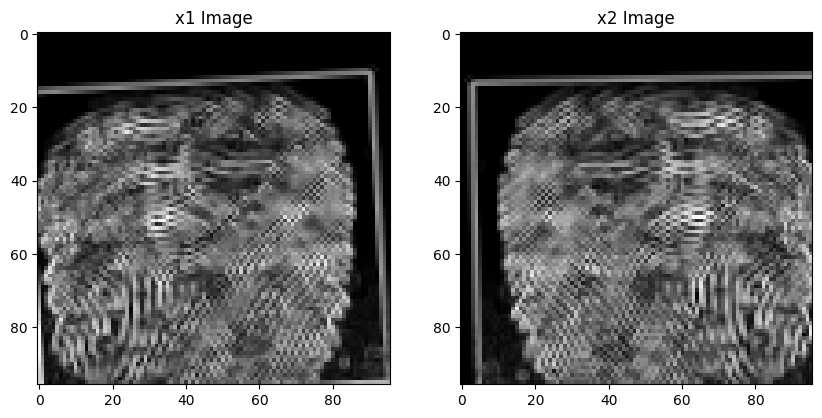

Batch 2:
x1 batch shape: (32, 96, 96, 1)
x2 batch shape: (32, 96, 96, 1)
Labels shape: (32, 1)


In [ ]:
import matplotlib.pyplot as plt


for i, (inputs, labels) in enumerate(train_gen):
    
    print(f"Batch {i + 1}:")
    print(f"x1 batch shape: {inputs[0].shape}")
    print(f"x2 batch shape: {inputs[1].shape}")
    print(f"Labels shape: {labels.shape}")

    
    if i == 0:  
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(inputs[0][0].squeeze(), cmap='gray')  
        plt.title('x1 Image')

        plt.subplot(1, 2, 2)
        plt.imshow(inputs[1][0].squeeze(), cmap='gray')  
        plt.title('x2 Image')

        plt.show()

    
    if i >= 1:
        break

In [ ]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('sobel_lenet_best.h5', save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,  
    callbacks=[checkpoint, early_stop, lr_scheduler],
    verbose=2  
)




Epoch 1/5


c:\Users\h4uh4\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


519/519 - 20s - 38ms/step - accuracy: 0.6775 - auc: 0.7326 - loss: 0.6105 - val_accuracy: 0.5001 - val_auc: 0.5000 - val_loss: 0.9046 - learning_rate: 1.0000e-03
Epoch 2/5


519/519 - 18s - 34ms/step - accuracy: 0.7037 - auc: 0.7525 - loss: 0.5913 - val_accuracy: 0.5023 - val_auc: 0.5538 - val_loss: 0.9032 - learning_rate: 1.0000e-03
Epoch 3/5


519/519 - 18s - 35ms/step - accuracy: 0.7042 - auc: 0.7552 - loss: 0.5884 - val_accuracy: 0.5119 - val_auc: 0.7269 - val_loss: 0.8896 - learning_rate: 1.0000e-03
Epoch 4/5
519/519 - 18s - 35ms/step - accuracy: 0.6960 - auc: 0.7520 - loss: 0.5923 - val_accuracy: 0.5099 - val_auc: 0.5543 - val_loss: 0.9466 - learning_rate: 1.0000e-03
Epoch 5/5
519/519 - 18s - 34ms/step - accuracy: 0.7127 - auc: 0.7638 - loss: 0.5800 - val_accuracy: 0.5014 - val_auc: 0.4606 - val_loss: 1.0205 - learning_rate: 1.0000e-03


In [ ]:

model.save('C:/Users/h4uh4/OneDrive/Desktop/FinalCompareFriedman/Model_Lenet/HasilModelLenet/sobel_lenet_final_model.keras')



c:\Users\h4uh4\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Shapes: (5527, 96, 96, 1) (5527, 96, 96, 1) (5527, 1)


  0%|          | 0/100 [00:00<?, ?it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


  1%|          | 1/100 [00:02<03:19,  2.01s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


  2%|▏         | 2/100 [00:03<03:01,  1.86s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


  3%|▎         | 3/100 [00:05<03:12,  1.99s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


  4%|▍         | 4/100 [00:07<03:06,  1.94s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


  5%|▌         | 5/100 [00:09<02:58,  1.88s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


  6%|▌         | 6/100 [00:11<02:52,  1.84s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


  7%|▋         | 7/100 [00:13<02:51,  1.85s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


  8%|▊         | 8/100 [00:15<02:53,  1.88s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


  9%|▉         | 9/100 [00:16<02:46,  1.83s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 10%|█         | 10/100 [00:18<02:46,  1.85s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 11%|█         | 11/100 [00:20<02:39,  1.79s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 12%|█▏        | 12/100 [00:22<02:42,  1.85s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 13%|█▎        | 13/100 [00:24<02:42,  1.86s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 14%|█▍        | 14/100 [00:26<02:37,  1.83s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 15%|█▌        | 15/100 [00:27<02:33,  1.81s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 16%|█▌        | 16/100 [00:29<02:29,  1.77s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 17%|█▋        | 17/100 [00:31<02:32,  1.84s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 18%|█▊        | 18/100 [00:32<02:23,  1.74s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 19%|█▉        | 19/100 [00:34<02:15,  1.67s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 20%|██        | 20/100 [00:35<02:08,  1.61s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 21%|██        | 21/100 [00:37<02:04,  1.58s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 22%|██▏       | 22/100 [00:38<02:01,  1.55s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 23%|██▎       | 23/100 [00:40<01:57,  1.53s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 24%|██▍       | 24/100 [00:41<01:56,  1.53s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 25%|██▌       | 25/100 [00:43<01:53,  1.51s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 26%|██▌       | 26/100 [00:44<01:51,  1.51s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 27%|██▋       | 27/100 [00:46<01:49,  1.50s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 28%|██▊       | 28/100 [00:47<01:49,  1.52s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 29%|██▉       | 29/100 [00:49<01:46,  1.51s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 30%|███       | 30/100 [00:50<01:45,  1.50s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 31%|███       | 31/100 [00:52<01:43,  1.49s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 32%|███▏      | 32/100 [00:53<01:42,  1.51s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 33%|███▎      | 33/100 [00:55<01:40,  1.50s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 34%|███▍      | 34/100 [00:56<01:38,  1.50s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 35%|███▌      | 35/100 [00:58<01:36,  1.49s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 36%|███▌      | 36/100 [00:59<01:36,  1.51s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 37%|███▋      | 37/100 [01:01<01:36,  1.53s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


 38%|███▊      | 38/100 [01:03<01:45,  1.70s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 39%|███▉      | 39/100 [01:05<01:45,  1.73s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 40%|████      | 40/100 [01:07<01:46,  1.78s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 41%|████      | 41/100 [01:09<01:44,  1.78s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 42%|████▏     | 42/100 [01:10<01:42,  1.76s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 43%|████▎     | 43/100 [01:12<01:41,  1.78s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 44%|████▍     | 44/100 [01:14<01:39,  1.78s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 45%|████▌     | 45/100 [01:16<01:36,  1.76s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 46%|████▌     | 46/100 [01:17<01:34,  1.76s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 47%|████▋     | 47/100 [01:19<01:33,  1.76s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 48%|████▊     | 48/100 [01:21<01:30,  1.75s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 49%|████▉     | 49/100 [01:23<01:29,  1.75s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 50%|█████     | 50/100 [01:24<01:27,  1.75s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 51%|█████     | 51/100 [01:26<01:25,  1.74s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 52%|█████▏    | 52/100 [01:28<01:23,  1.74s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 53%|█████▎    | 53/100 [01:30<01:22,  1.75s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 54%|█████▍    | 54/100 [01:31<01:20,  1.75s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 55%|█████▌    | 55/100 [01:33<01:18,  1.74s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 56%|█████▌    | 56/100 [01:35<01:16,  1.73s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 57%|█████▋    | 57/100 [01:37<01:14,  1.73s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 58%|█████▊    | 58/100 [01:38<01:12,  1.73s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 59%|█████▉    | 59/100 [01:40<01:10,  1.73s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 60%|██████    | 60/100 [01:42<01:11,  1.78s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 61%|██████    | 61/100 [01:44<01:09,  1.79s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 62%|██████▏   | 62/100 [01:45<01:07,  1.77s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 63%|██████▎   | 63/100 [01:47<01:06,  1.80s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 64%|██████▍   | 64/100 [01:49<01:05,  1.82s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 65%|██████▌   | 65/100 [01:51<01:04,  1.85s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 66%|██████▌   | 66/100 [01:53<01:02,  1.85s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 67%|██████▋   | 67/100 [01:55<00:59,  1.81s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 68%|██████▊   | 68/100 [01:56<00:56,  1.78s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 69%|██████▉   | 69/100 [01:58<00:54,  1.77s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 70%|███████   | 70/100 [02:00<00:53,  1.79s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 71%|███████   | 71/100 [02:02<00:51,  1.78s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 72%|███████▏  | 72/100 [02:03<00:49,  1.77s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 73%|███████▎  | 73/100 [02:05<00:49,  1.82s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 74%|███████▍  | 74/100 [02:07<00:47,  1.83s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 75%|███████▌  | 75/100 [02:09<00:46,  1.86s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 76%|███████▌  | 76/100 [02:11<00:42,  1.79s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 77%|███████▋  | 77/100 [02:13<00:41,  1.81s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 78%|███████▊  | 78/100 [02:14<00:38,  1.77s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 79%|███████▉  | 79/100 [02:16<00:35,  1.67s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 80%|████████  | 80/100 [02:17<00:32,  1.62s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 81%|████████  | 81/100 [02:19<00:29,  1.56s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 82%|████████▏ | 82/100 [02:20<00:27,  1.52s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 83%|████████▎ | 83/100 [02:22<00:25,  1.49s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 84%|████████▍ | 84/100 [02:23<00:23,  1.48s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 85%|████████▌ | 85/100 [02:24<00:21,  1.46s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 86%|████████▌ | 86/100 [02:26<00:20,  1.46s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 87%|████████▋ | 87/100 [02:27<00:18,  1.45s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 88%|████████▊ | 88/100 [02:29<00:17,  1.47s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 89%|████████▉ | 89/100 [02:30<00:16,  1.46s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 90%|█████████ | 90/100 [02:32<00:14,  1.45s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 91%|█████████ | 91/100 [02:33<00:13,  1.45s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 92%|█████████▏| 92/100 [02:35<00:11,  1.45s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 93%|█████████▎| 93/100 [02:36<00:10,  1.45s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 94%|█████████▍| 94/100 [02:37<00:08,  1.44s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 95%|█████████▌| 95/100 [02:39<00:07,  1.44s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 96%|█████████▌| 96/100 [02:40<00:05,  1.44s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


 97%|█████████▋| 97/100 [02:42<00:04,  1.46s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


 98%|█████████▊| 98/100 [02:44<00:03,  1.54s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


 99%|█████████▉| 99/100 [02:45<00:01,  1.64s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


100%|██████████| 100/100 [02:47<00:00,  1.68s/it]

Bootstrap AUC mean: 0.8290
95% Confidence Interval: [0.8173, 0.8397]
Indices dipilih: [ 0 24 49 74 99]
Nilai AUC diambil: [0.83752124 0.83395912 0.82009694 0.8355127  0.83900885]


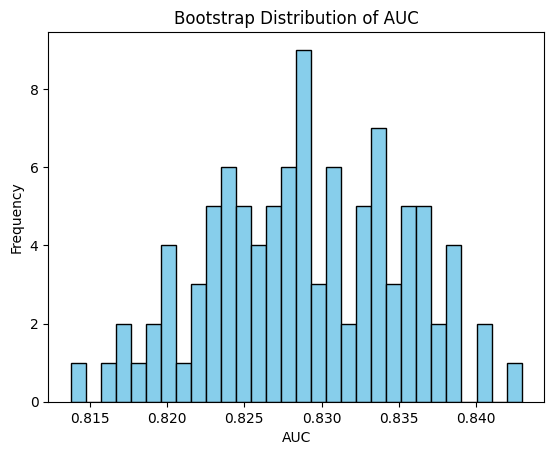

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm import tqdm


test_gen = PairGenerator(x_test_sobel, y_test, x_test_sobel, y_test, batch_size=32, augment_fn=augment)

x1_list, x2_list, y_list = [], [], []
for i in range(len(test_gen)):
    (x1_batch, x2_batch), y_batch = test_gen[i]
    x1_list.append(x1_batch)
    x2_list.append(x2_batch)
    y_list.append(y_batch)

x_test_1 = np.concatenate(x1_list, axis=0)
x_test_2 = np.concatenate(x2_list, axis=0)
y_test_full = np.concatenate(y_list, axis=0)
y_test_full = y_test_full[:len(x_test_1)]  

print("Shapes:", x_test_1.shape, x_test_2.shape, y_test_full.shape)


model_local = load_model('C:/Users/h4uh4/OneDrive/Desktop/FinalCompareFriedman/Model_Lenet/HasilModelLenet/sobel_lenet_final_model.keras')

B = 100
n = len(x_test_1)
num_classes = len(np.unique(y_test_full))
results = []

for seed in tqdm(range(B), total=B):
    np.random.seed(seed)
    idx = np.random.choice(n, size=n, replace=True)
    x1_bs, x2_bs, y_bs = x_test_1[idx], x_test_2[idx], y_test_full[idx]

    y_pred_probs = model_local.predict([x1_bs, x2_bs], batch_size=32)
    y_bs_bin = label_binarize(y_bs, classes=range(num_classes))

    auc = roc_auc_score(y_bs_bin, y_pred_probs, multi_class='ovr', average='macro')
    results.append(auc)

auc_scores = np.array(results)
mean_auc = np.mean(auc_scores)
ci_lower, ci_upper = np.percentile(auc_scores, [2.5, 97.5])

print(f"Bootstrap AUC mean: {mean_auc:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")


indices = np.linspace(0, len(auc_scores) - 1, 5, dtype=int)
sampled_aucs = auc_scores[indices]

print("Indices dipilih:", indices)
print("Nilai AUC diambil:", sampled_aucs)


with open("sobel_bootstrap_auc_results.txt", "w") as f:
    f.write("Sampled 5 AUC values (berjarak):\n")
    for val in sampled_aucs:
        f.write(f"{val:.6f}\n")
    f.write("\n")
    f.write(f"Bootstrap AUC mean: {mean_auc:.4f}\n")
    f.write(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]\n\n")
    f.write("All Bootstrap AUC scores:\n")
    for val in auc_scores:
        f.write(f"{val:.6f}\n")


plt.hist(auc_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Bootstrap Distribution of AUC')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.show()


c:\Users\h4uh4\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7505 - auc: 0.8910 - loss: 0.5167
Test Loss: 0.5150558948516846
Test Accuracy: 0.7552017569541931
Test AUC: 0.8934462666511536


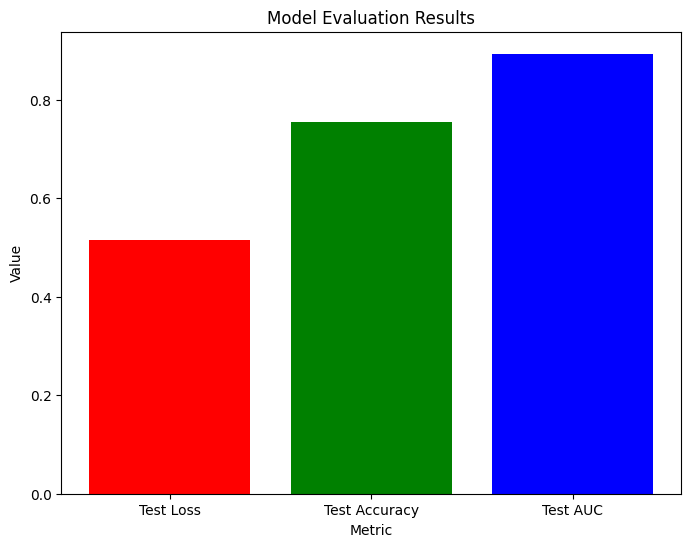

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

test_gen = PairGenerator(x_test_sobel, y_test, x_test_sobel, y_test, batch_size=32, augment_fn=None)


test_loss, test_accuracy, test_auc = model.evaluate(test_gen)  


print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")


results = [test_loss, test_accuracy, test_auc]
labels = ['Test Loss', 'Test Accuracy', 'Test AUC']


plt.figure(figsize=(8, 6))
plt.bar(labels, results, color=['red', 'green', 'blue'])


plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Model Evaluation Results')


plt.show()
